In [ ]:
# pip install tensorflow matplotlib scikit-learn keras-tuner keras

In [1]:
import gc

import tensorflow as tf
%matplotlib inline

from tensorflow.keras import backend as K # Importing Keras backend (by default it is Tensorflow)
from tensorflow.keras.callbacks import EarlyStopping # Callback for early stopping
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization # Layers to be used for building our model
from tensorflow.keras.models import Model # The class used to create a model
# from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.random import set_seed
from sklearn.model_selection import train_test_split
from kerastuner.tuners import Hyperband

import matplotlib.pyplot as plt
import numpy as np

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.16.1


/var/folders/dp/w8c9sz4j6rxbq418ktj26ycr0000gn/T/ipykernel_72237/2058656791.py:15: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import Hyperband


In [2]:
# Load the dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [3]:
# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Number of unique classes in the CIFAR-10 dataset:  10


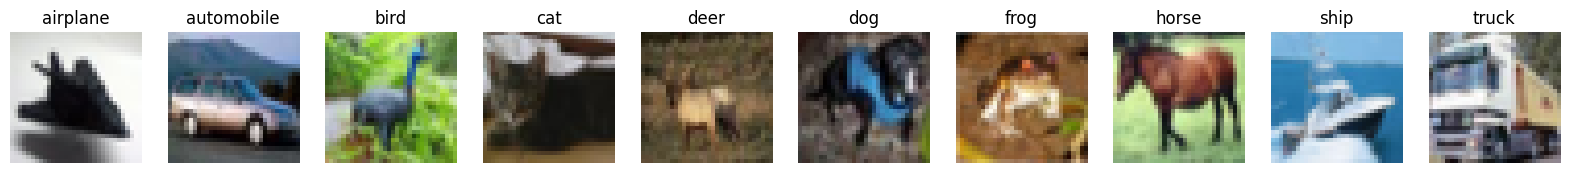

In [4]:
unique_classes = np.unique(y_train)
unique_classes_len = len(unique_classes)
print("Number of unique classes in the CIFAR-10 dataset: ", unique_classes_len)

unique_classes, first_occurrence_indices = np.unique(y_train, return_index=True)

# Normalize pixel values to be between 0 and 1 for display
x_train_normalized = x_train / 255.0

# Display one image from each class with class names
fig, axs = plt.subplots(1, len(unique_classes), figsize=(20, 2))
for i, idx in enumerate(first_occurrence_indices):
    axs[i].imshow(x_train_normalized[idx])
    axs[i].axis('off')
    axs[i].set_title(class_names[unique_classes[i]])
plt.show()

In [5]:
# Normalize pixel values to be between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

# Flatten the images into 1D vectors (32x32x3 images into 3072-dimensional vectors)
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

# Convert class vectors to binary class matrices (for use with categorical_crossentropy)
y_train = to_categorical(y_train, unique_classes_len)
y_test = to_categorical(y_test, unique_classes_len)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

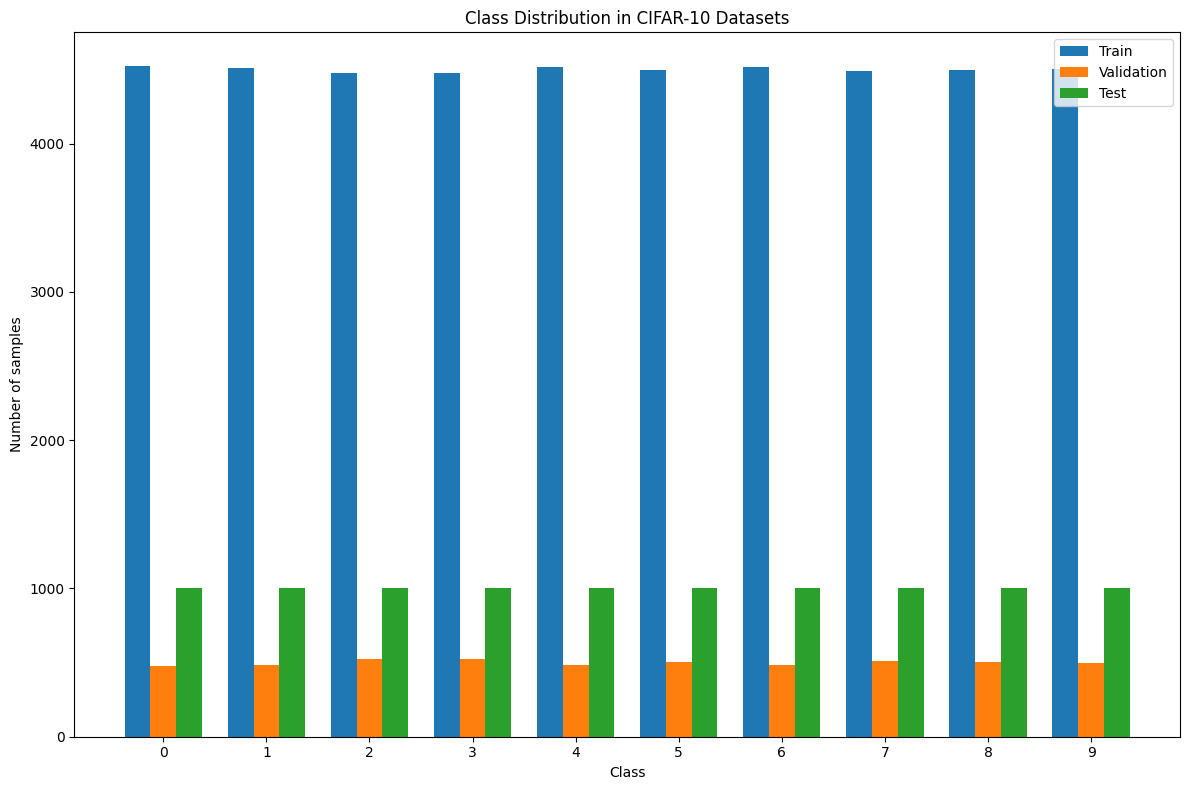

In [6]:
# Function to calculate class distribution
def calculate_class_distribution(y_dataset):
    # Since the labels are one-hot encoded, summing them will give us the count per class
    class_distribution = np.sum(y_dataset, axis=0)
    return class_distribution

# Calculate class distributions
train_class_distribution = calculate_class_distribution(y_train)
val_class_distribution = calculate_class_distribution(y_val)
test_class_distribution = calculate_class_distribution(y_test)

# Plotting the distributions
def plot_class_distribution(train_dist, val_dist, test_dist, unique_classes_len):
    fig, ax = plt.subplots(figsize=(12, 8))
    index = np.arange(unique_classes_len)
    bar_width = 0.25

    # Plot each distribution with an offset for the bar position
    plt.bar(index, train_dist, bar_width, label='Train')
    plt.bar(index + bar_width, val_dist, bar_width, label='Validation')
    plt.bar(index + 2 * bar_width, test_dist, bar_width, label='Test')

    plt.xlabel('Class')
    plt.ylabel('Number of samples')
    plt.title('Class Distribution in CIFAR-10 Datasets')
    plt.xticks(index + bar_width, range(unique_classes_len))
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot
plot_class_distribution(train_class_distribution, val_class_distribution, test_class_distribution, unique_classes_len)


In [7]:
def build_model(
    optimizer,
    neurons_per_layer,
    dropout_rates=None,
    batch_norm=False
):

    np.random.seed(1402) # Define the seed for numpy to have reproducible experiments.
    set_seed(1996) # Define the seed for Tensorflow to have reproducible experiments.

    # Define the input layer.
    input = Input(
        shape=(3072,),
        name='Input'
    )

    x = input
    # Define the remaining hidden layers.
    for i, neurons in enumerate(neurons_per_layer):
        x = Dense(units=neurons, kernel_initializer='glorot_uniform', activation='relu', name=f'Hidden-{i+1}')(x)
        if batch_norm & i > 0:
            x = BatchNormalization()(x)
        if dropout_rates is not None:
            x = Dropout(dropout_rates[i], name=f'Dropout-{i+1}')(x)  # Apply specified dropout rate for the layer

    # Define the output layer.
    output = Dense(
        units=10,
        kernel_initializer='glorot_uniform',
        activation='softmax',
        name='Output'
    )(x)

    # Define the model and train it.
    model = Model(inputs=input, outputs=output)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [8]:
def build_model_with_hp(hp):
    optimizer_choice = hp.Choice('optimizer', values=['adam', 'sgd'])

    if optimizer_choice == 'adam':
        optimizer = tf.keras.optimizers.Adam(
            learning_rate=hp.Float('adam_learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
        )
    elif optimizer_choice == 'sgd':
        optimizer = tf.keras.optimizers.SGD(
            learning_rate=hp.Float('sgd_learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
        )


    # Define the number of layers based on a hyperparameter
    hidden_layers = hp.Int('hidden_layers', min_value=0, max_value=3, step=1)

    dropout_rates = [hp.Float(f'dropout_rate_layer{i}', min_value=0.0, max_value=0.5, step=0.1) for i in range(1, hidden_layers + 1)]

    batch_norm = hp.Boolean('batch_norm')

    neurons_per_layer = []
    for i in range(1, hidden_layers+1):
        # For each layer, define a hyperparameter for the number of neurons
        neurons = hp.Int(f'neurons_layer{i}', min_value=64, max_value=512, step=64)
        neurons_per_layer.append(neurons)

     # Build and return the model
    return build_model(
        optimizer=optimizer,
        neurons_per_layer=neurons_per_layer,
        dropout_rates=dropout_rates,
        batch_norm=batch_norm
    )

In [9]:
tuner = Hyperband(
    build_model_with_hp,
    objective='val_accuracy',
    max_epochs=10,
    directory='my_dir',
    project_name='2',

)

In [11]:
def search_best_batch_size(x_train, y_train, x_val, y_val, batch_sizes=[64, 128, 256, 512]):
    tuners = {}  # Store tuners by batch size
    best_batch_size = None
    best_val_accuracy = 0

    for batch_size in batch_sizes:
        print(f"Testing batch size: {batch_size}")

        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        tuner = Hyperband(
            build_model_with_hp,
            objective='val_accuracy',
            max_epochs=10,
            directory='my_dir',
            project_name=f'1batch_size_{batch_size}',
        )

        tuner.search(x_train, y_train, validation_data=(x_val, y_val), callbacks=[early_stopping], batch_size=batch_size)

        best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]
        val_accuracy = best_trial.score

        print(f"Batch size {batch_size} - Best Validation Accuracy: {val_accuracy}")

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_batch_size = batch_size

        # Store the tuner for later retrieval
        tuners[batch_size] = tuner

    print(f"Best batch size: {best_batch_size} with Validation Accuracy: {best_val_accuracy}")

    # Return the best batch size and the tuners dictionary
    return best_batch_size, tuners


In [12]:
bbs, tuners = search_best_batch_size(x_train, y_train, x_val, y_val)

Trial 30 Complete [00h 00m 03s]
val_accuracy: 0.3774000108242035

Best val_accuracy So Far: 0.446399986743927
Total elapsed time: 00h 02m 35s
Batch size 512 - Best Validation Accuracy: 0.446399986743927
Best batch size: 128 with Validation Accuracy: 0.4708000123500824


In [16]:
tuners

{64: <keras_tuner.src.tuners.hyperband.Hyperband at 0x2a0168a50>,
 128: <keras_tuner.src.tuners.hyperband.Hyperband at 0x2a016be50>,
 256: <keras_tuner.src.tuners.hyperband.Hyperband at 0x29f57d210>,
 512: <keras_tuner.src.tuners.hyperband.Hyperband at 0x2a0247d50>}

In [22]:
tuner_best_model = tuners[bbs].get_best_models(num_models=1)[0]
tuner_best_model.evaluate(x_test, y_test, verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step - accuracy: 0.4891 - loss: 1.4396


[1.4503551721572876, 0.48590001463890076]

In [32]:
best_hps = tuners[bbs].get_best_hyperparameters(num_trials=1)[0]
print(best_hps.values)

{'optimizer': 'adam', 'adam_learning_rate': 0.00011819492792065851, 'hidden_layers': 3, 'batch_norm': True, 'sgd_learning_rate': 0.0005152886366624843, 'dropout_rate_layer1': 0.0, 'dropout_rate_layer2': 0.2, 'neurons_layer1': 128, 'neurons_layer2': 512, 'dropout_rate_layer3': 0.1, 'neurons_layer3': 256, 'tuner/epochs': 10, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}


In [25]:
# Generate predictions
# If your model outputs logits or probabilities, you might need to convert these to the class predictions
# For example, using `np.argmax(model.predict(x_test), axis=-1)` for multiclass classification
predictions = tuner_best_model.predict(x_test)
predictions = np.argmax(predictions, axis=-1) # This step is for models that output one-hot encoded predictions


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step


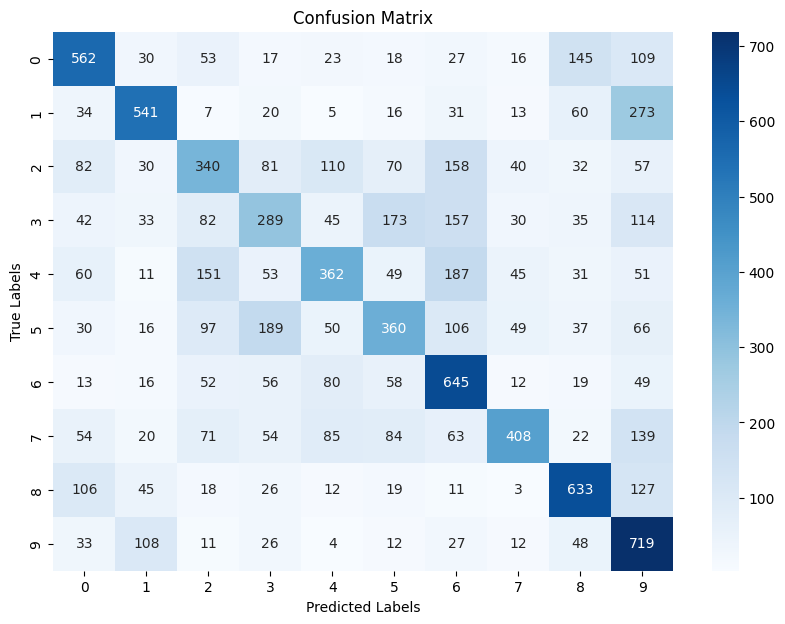

In [29]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming `predictions` are the raw outputs from your model, e.g., softmax probabilities
# Convert predictions and true labels from one-hot encoded to class indices
predictions = np.argmax(tuner_best_model.predict(x_test), axis=-1)
y_test_indices = np.argmax(y_test, axis=-1)  # Only if y_test is one-hot encoded

# Calculate the confusion matrix
cm = confusion_matrix(y_test_indices, predictions)

# Plot the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [46]:
def clean_up(model):
    K.clear_session()
    del model
    gc.collect()

In [68]:
clean_up(best_model)